In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')


In [2]:
def parse_one_annotation(anno, image_dir): #이미지 어노테이션 정보를 파싱하여 필요한 정보들을 추출하여 딕셔너리 형태로 반환
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation


In [3]:

def generate_tfexample(anno): # tf.train.Example 형식으로 이미지 어노테이션 정보를 가진 데이터를 생성

    # byte 인코딩을 위한 함수
    def _bytes_feature(value): 
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']
    # 관절 위치와 관절 가시성의 값을 음수가 아닌 정수로 변환하여 저장
    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = { 
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }
    #tf.train.Example 형식으로 변환하여 반환
    return tf.train.Example(features=tf.train.Features(feature=feature))


In [4]:
def chunkify(l, n): #리스트를 여러 개의 작은 리스트로 나누는 역할
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results


In [5]:
@ray.remote #함수를 비동기적으로 실행
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString()) #객체를 바이트 형식으로 변환

    print('finished building tf records for ' + path)

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote( #remote 함수를 사용하면 원격으로 함수를 실행하여 병렬 처리
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures) #비동기 작업들이 완료될 때까지 대기


In [ ]:

num_train_shards = 64 #훈련용 TFRecord 파일의 개수
num_val_shards = 8 #검증용 TFRecord 파일의 개수
ray.shutdown() #기존에 실행 중이던 Ray 클러스터를 종료
ray.init() #새로운 Ray 클러스터를 초기화

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [ #훈련 데이터의 이미지 어노테이션 정보
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train') #어노테이션 정보를 사용하여 TFRecord 파일들을 생성
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))


In [6]:

def parse_tfexample(example): #바이트 데이터를 딕셔너리 형태로 반환
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description) #각각의 데이터는 텐서 형식으로 캡슐화(안에 딕셔너리)


In [10]:
#TFRecord 파일에서 읽은 데이터를 전처리하여 학습에 사용할 이미지와 관련된 히트맵 데이터를 생성
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape
    #TFRecord 파일에서 읽은 데이터를 입력으로 받아 전처리된 이미지와 히트맵 데이터를 반환
    def __call__(self, example): 
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

    #이미지를 관심 영역(ROI)으로 잘라내는 함수
    def crop_roi(image, features, margin=0.2): #키포인트 위치 정보를 바탕으로 roi를 잘라내고, 키포인트의 위치를 재조정하는 함수
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0

        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        # 키포인트의 상대적인 위치
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return image, effective_keypoint_x, effective_keypoint_y

    #특정 위치에 대한 2D 가우시안 분포를 생성하여 히트맵 형태로 반환
    def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
        #sigma: 가우시안 분포의 표준 편차를 결정하는 값으로, 기본값은 1입니다.
        #scale: 가우시안 히트맵의 크기를 결정하는 값으로, 기본값은 12입니다.
        heatmap = tf.zeros((height, width))

        #히트맵이 영향을 미치는 범위를 계산
        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
            return heatmap

        #가우시안 플롯의 x, y 좌표 그리드를 생성
        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2
        #가우시안 분포 공식을 이용하여 플롯 값을 계산
        gaussian_patch = tf.cast(tf.math.exp(
            -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                                 dtype=tf.float32)
        #이미지를 벗어나지 않는 영역
        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0
        #히트맵 업데이트
        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1

        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())
        #관절 위치를 중심으로 하는 가우시안 히트맵을 생성하여, 이미지 상에서 관절의 위치 정보를 나타내는데 사용
        return heatmap
    #관절 위치 정보를 기반으로 히트맵 데이터를 생성하는 함수입니다. 각 관절의 위치를 가우시안 히트맵으로 변환하여 반환합니다.
    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(example): #바이트 데이터를 딕셔너리 형태로 반환
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example, image_feature_description) #각각의 데이터는 텐서 형식으로 캡슐화(안에 딕셔너리)



In [ ]:
#TFRecords 파일들로부터 데이터셋을 생성하고 전처리를 수행
def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords) #tf.data.Dataset을 생성
    dataset = tf.data.TFRecordDataset(dataset) #TFRecords 파일들을 불러와 데이터셋으로 변환
    dataset = dataset.map( #전처리를 수행
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #데이터를 비동기적으로 미리 가져와서 학습 속도를 향상

    return dataset

In [11]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    #다음 계층과의 shortcut connection을 위해 identity 매핑을 추가
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

def HourglassModule(inputs, order, filters, num_residual):
    #재귀적인 구조를 활용하여 Hourglass 모듈을 구현
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

shgn_model = StackedHourglassNetwork()
shgn_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________

In [12]:
def Simplebaseline(input_shape=(256, 256, 3)):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

    def _make_deconv_layer(num_deconv_layers):
        seq_model = tf.keras.models.Sequential()

        for _ in range(num_deconv_layers):
            seq_model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', activation='relu'))
            seq_model.add(BatchNormalization(momentum=0.1))
            seq_model.add(ReLU())
        return seq_model

    upconv = _make_deconv_layer(3)

    final_layer = tf.keras.layers.Conv2D(16, kernel_size=1,strides=1,padding='same')  # Assuming 16 as the number of output classes

#     def Simplebaseline(input_shape=(256, 256, 3)): #scope 에러나서 함수 안에 넣으니 됨
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder (ResNet50)
    x = resnet(inputs, training=False) 

    # Decoder (Upconvolution layers)
    x = upconv(x)

    # Final output layer
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

# Create the Simplebaseline model
sbl_model = Simplebaseline()

# Print model summary
sbl_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_244 (Conv2D)          (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [13]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 name='shgn'):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.name = name

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self): # 학습률을 감소시키는 함수
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch): #학습률을 에포크에 따라 조정하는 함수
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs): #손실 함수를 계산하는 함수
        loss = 0. #자료형 안맞다고해서 float으로 변경함
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
#                 tf.print('Trained batch', num_train_batches, 'batch loss', # 길어져서 제외
#                          batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 tf.print('Validated batch', num_val_batches, 'batch loss',
#                          batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        train_losses = []
        val_losses = []
        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            train_losses.append(train_loss)
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            val_losses.append(val_loss)
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(self.name)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        with open(f'{PROJECT_PATH}/{self.name}_train_losses.txt', 'w') as file: #loss 값 저장
            for loss in train_losses:
                file.write(str(loss.numpy()) + '\n')

        with open(f'{PROJECT_PATH}/{self.name}_val_losses.txt', 'w') as file:
            for loss in val_losses:
                file.write(str(loss.numpy()) + '\n')
        
        return self.best_model

    def save_model(self, name): #저장 권한으로 폴더 위치 변경
        model_name = PROJECT_PATH + '/{}.h5'.format(name) 
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))



In [15]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)
epochs = 5
learning_rate = 1e-2 
num_heatmap = 16
batch_size = 16
train_tfrecords = f'{TFRECORD_PATH}/train*.tfrecords'
val_tfrecords = f'{TFRECORD_PATH}/val*.tfrecords'


In [16]:
def shgn_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords,name):
    strategy = tf.distribute.MirroredStrategy() #다중 GPU로 모델을 병렬 처리하는 데 사용
    global_batch_size = strategy.num_replicas_in_sync * batch_size #장치 수와 지정된 배치 크기를 곱하여 전역 배치 크기를 계산
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope(): #분산 전략의 스코프 내에서 모델과 트레이너 객체를 생성
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
#         model = Simplebaseline()
        
        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
            name=name) #파일 이름 정하기

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)
#tf.data.Dataset의 옵션들이 그래프 구성 시점에서 고정적으로 결정되는 것이 아니라, 
#그래프 실행 시점에서 결정되므로, 이전에 정적으로 설정되었던 옵션들이 그대로 보존되지 않을 수 있다는 것 경고 메시지
stackedHourglass = shgn_train(epochs, learning_rate, num_heatmap, 
                              batch_size, train_tfrecords, val_tfrecords,name='shgn')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Epoch 1 train loss 1.490714430809021
Epoch 1 val loss 1.3882858753204346
Model /aiffel/aiffel/mpii/shgn.h5 saved.
Start epoch 2 with learning rate 0.01
Start distributed traininng...
Epoch 2 train loss 1.324661135673523
Epoch 2 val loss 1.268324375152588
Model /aiffel/aiffel/mpii/shgn.h5 saved.
Start epoch 3 with learning rate 0.01
Start distributed traininng...
Epoch 3 train loss 1.2582623958587646
Epoch 3 val loss 1.250481367111206
Model /aiffel/aiffel/mpii/shgn.h5 saved.
Start epoch 4 with learning rate 0.01
Start distributed traininng...
Epoch 4 train loss 1.218810796737671
Epoch 4 val loss 1.2418235540390015
Model /aiffel/aiffel/mpii/shgn.h5 saved.
Start epoch 5 with learning rate 0.01
Start distributed traininng...
Epoch 5 train loss 1.1926871538162231
Epoch 5 val loss 1.2118642330169678
Model /aiffel/aiffel/mpii/shgn.h5 saved.


In [17]:
def sbl_train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords,name):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        
#         model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        model = Simplebaseline()
        
        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate, #simplebaseline은 0.001로 되어있긴함
            name=name) #파일 이름 정하기

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)
#tf.data.Dataset의 옵션들이 그래프 구성 시점에서 고정적으로 결정되는 것이 아니라, 
#그래프 실행 시점에서 결정되므로, 이전에 정적으로 설정되었던 옵션들이 그대로 보존되지 않을 수 있다는 것 경고 메시지
stackedHourglass = sbl_train(epochs, learning_rate, num_heatmap, 
                             batch_size, train_tfrecords, val_tfrecords,name='sbl')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.01
Start distributed traininng...
Epoch 1 train loss 6.849641799926758
Epoch 1 val loss 6.448667049407959
Model /aiffel/aiffel/mpii/sbl.h5 saved.
Start epoch 2 with learning rate 0.01
Start distributed traininng...
Epoch 2 train loss 6.396518230438232
Epoch 2 val loss 6.321486473083496
Model /aiffel/aiffel/mpii/sbl.h5 saved.
Start epoch 3 with learning rate 0.01
Start distributed traininng...
Epoch 3 train loss 6.383885383605957
Epoch 3 val loss 6.318207740783691
Model /aiffel/aiffel/mpii/sbl.h5 saved.
Start epoch 4 with learning rate 0.01
Start distributed traininng...
Epoch 4 train loss 6.380834102630615
Epoch 4 val loss 6.298068523406982
Model /aiffel/aiffel/mpii/sbl.h5 saved.
Start epoch 5 with learning rate 0.01
Start distributed traininng...
Epoch 5 train loss 6.375085353851318
Epoch 5 val loss 6.338813781738281


모델이 잘 구현되어있는지 모르겠고, resnet 가져올때 training=False로 해도 summary에 trainable params 수치가 올라가 있어서 놔둠
github에선 학습률이 1e-3인데 1e-2로 한 것도 차이가 좀 있을듯함

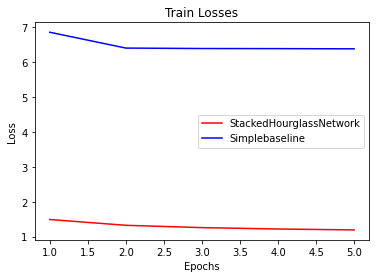

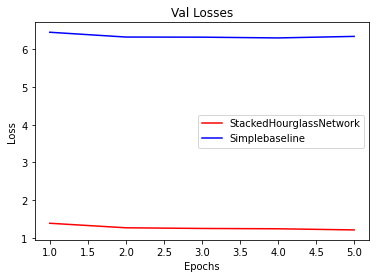

In [18]:
#손실 저장한 파일 불러오기
#StackedHourglassNetwork
with open(f'{PROJECT_PATH}/shgn_train_losses.txt', 'r') as file:
    shgl_train_losses = [float(line.strip()) for line in file.readlines()]

with open(f'{PROJECT_PATH}/shgn_val_losses.txt', 'r') as file:
    shgl_val_losses = [float(line.strip()) for line in file.readlines()]

#Simplebaseline
with open(f'{PROJECT_PATH}/sbl_train_losses.txt', 'r') as file:
    sbl_train_losses = [float(line.strip()) for line in file.readlines()]

with open(f'{PROJECT_PATH}/sbl_val_losses.txt', 'r') as file:
    sbl_val_losses = [float(line.strip()) for line in file.readlines()]
    
# 그래프 그리기
epochs = range(1, len(shgl_train_losses) + 1)
plt.plot(epochs, shgl_train_losses,'r')
plt.plot(epochs, sbl_train_losses, 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Losses')
plt.legend(['StackedHourglassNetwork','Simplebaseline'])
plt.show()

epochs = range(1, len(sbl_train_losses) + 1)
plt.plot(epochs, shgl_val_losses,'r')
plt.plot(epochs, sbl_val_losses, 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Val Losses')
plt.legend(['StackedHourglassNetwork','Simplebaseline'])
plt.show()

In [19]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

def find_max_coordinates(heatmaps): #히트맵을 기반으로 각 키포인트의 가장 가능성 있는 위치를 찾음
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0) #각 열에서 최대값의 인덱스를 찾습니다.
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

def extract_keypoints_from_heatmap(heatmaps): #히트맵을 기반으로 예측된 각 관절(키포인트)의 좌표를 추출하는 함수
    max_keypoints = find_max_coordinates(heatmaps)
    #히트맵을 모서리를 0으로 패딩하여, 히트맵 내에서 관절 좌표를 기반으로 하위 픽셀을 검사
    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1 #해당 키포인트를 중심으로 3x3 패치
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i] #3x3 패치를 추출
        patch[1][1] = 0 #패치 중앙의 값(해당 키포인트의 값)을 0으로 설정
        
        index = np.argmax(patch) #패치에서 가장 높은 값(다음 최대값)의 인덱스
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4 #다음 최대값과 현재 최대값 사이의 y좌표 차이를 계산
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x # 현재 키포인트의 x좌표에 x좌표 차이를 더하여 조정된 x좌표를 계산
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64) #추정된 키포인트 좌표를 이미지 크기에 맞도록 0에서 64 사이의 값으로 클리핑
    normalized_keypoints = adjusted_keypoints / 64 #0에서 1 사이의 정규화된 좌표로 변환
    return normalized_keypoints #이미지 내 각 관절의 상대적인 위치

def predict(model, image_path): #이미지에서 관절(키포인트)을 예측하는 함수
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False) # 추론 모드로 동작
    if type(outputs) != list: #리스트 형태가 아니면 리스트로 변환
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy() #마지막 출력의 히트맵을 추출하고, 차원을 하나 제거하여 2D 히트맵 형태
    kp = extract_keypoints_from_heatmap(heatmap) #히트맵을 기반으로 관절 좌표를 추출
    return image, kp

def draw_keypoints_on_image(image, keypoints, index=None): #관절 좌표를 이미지 위에 빨간색 점으로 표시
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i: #시각화할 관절의 인덱스를 선택하는 매개변수로, 주어지지 않으면 모든 관절을 시각화
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None): # 관절 좌표를 이어서 선으로 표시하여 스켈레톤을 구성
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()


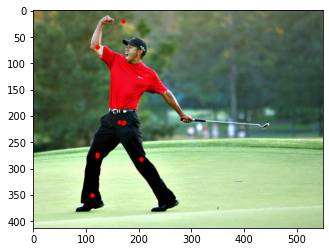

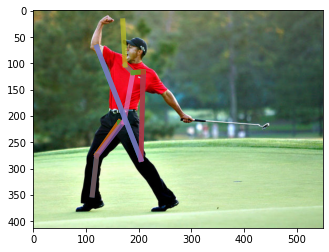

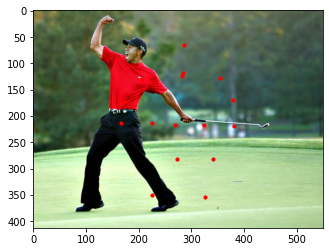

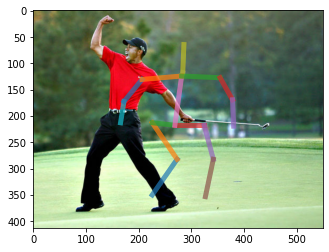

In [20]:
SHGN_WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'shgn.h5')
SBL_WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'sbl.h5')

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

shgn = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
shgn.load_weights(SHGN_WEIGHTS_PATH)

image, keypoints = predict(shgn, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

sbl = Simplebaseline()
sbl.load_weights(SBL_WEIGHTS_PATH)

image, keypoints = predict(sbl, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)